# Molecular docking via DC-QAOA

Drugs often work by binding to an active site of a protein, inhibiting or activating its function for some therapeutic purpose. Finding new candidate drugs is extremely difficult. The study of molecular docking helps guide this search and involves the prediction of how strongly a certain ligand (drug) will bind to its target (usually a protein).  

One of the primary challenges to molecular docking arises from the many geometric degrees of freedom present in proteins and ligands, making it difficult to predict the optimal orientation and assess if the drug is a good candidate or not. One solution is to formulate the problem as a mathematical optimization problem where the optimal solution corresponds to the most likely ligand-protein configuration. This optimization problem can be solved on a quantum computer using methods like the Quantum Approximate Optimization Algorithm (QAOA). This tutorial demonstrates how this [paper](https://arxiv.org/pdf/2308.04098) used digitized-counteradiabatic (DC) QAOA to study molecular docking.  This tutorial assumes you have an understanding of QAOA, if not, please see the CUDA-Q MaxCut tutorial found [here](https://nvidia.github.io/cuda-quantum/latest/applications/python/qaoa.html).

The next section provides more detail on the problem setup followed by CUDA-Q implementations below.

### Setting up the Molecular Docking Problem

The figure from the [paper](https://arxiv.org/pdf/2308.04098) provides a helpful diagram for understanding the workflow.

![docking](./images/docking.png)


There are 6 key steps:
1.  The experimental protein and ligand structures are determined and used to select pharmacores, or an important chemical group that will govern the chemical interactions.
2. Two labeled distance graphs (LAGs) of size $N$ and $M$ represent the protein and the ligand, respectively. Each node corresponds to a pharmacore and each edge weight corresponds to the distance between pharmacores.
3.  A $M*N$ node binding interaction graph (BIG) is created from the LAGs. Each node in the BIG graph corresponds to a pair of pharmacores, one from the ligand and the other from the protein. The existence of edges between nodes in the BIG graph are determined from the LAGs and correspond to interactions that can feesibly coexist. Therefore, cliques in the graph correspond to mutually possible interactions. 
4. The problem is mapped to a QAOA circuit and corresponding Hamiltonian. From there, the ground state solution is determined.
5.  The ground state will produce the maximum weighted clique which corresponds to the best (most strongly bound) orientation of the ligand and protein.
6.  The predicted docking structure is interpreted from the QAOA result and is used for further analysis.


### CUDA-Q Implementation

First, the appropriate libraries are imported and the `nvidia` backend is selected to run on GPUs if available.

In [1]:
import cudaq
from cudaq import spin
import numpy as np


The block below defines two of the BIG data sets from the paper. The first is a smaller example, but it can be swapped with the commented out example below at your discretion. The weights are specified for each node based on the nature of the ligand and protein pharmacores represented by the node.

In [2]:
# The two graph inputs from the paper

# BIG 1

nodes = [0, 1, 2, 3, 4, 5]
qubit_num = len(nodes)
edges = [[0, 1], [0, 2], [0, 4], [0, 5], [1, 2], [1, 3], [1, 5], [2, 3], [2, 4],
         [3, 4], [3, 5], [4, 5]]
non_edges = [
    [u, v] for u in nodes for v in nodes if u < v and [u, v] not in edges
]

print('Edges: ', edges)
print('Non-Edges: ', non_edges)

weights = [0.6686, 0.6686, 0.6686, 0.1453, 0.1453, 0.1453]
penalty = 6.0
num_layers = 3

# BIG 2 (More expensive simulation)
#nodes=[0,1,2,3,4,5,6,7]
#qubit_num=len(nodes)
#edges=[[0,1],[0,2],[0,5],[0,6],[0,7],[1,2],[1,4],[1,6],[1,7],[2,4],[2,5],[2,7],[3,4],[3,5],[3,6],\
#    [4,5],[4,6],[5,6]]
#non_edges=[[u,v] for u in nodes for v in nodes if u<v and [u,v] not in edges]
#print('Edges: ', edges)
#print('Non-edges: ', non_edges)
#weights=[0.6686,0.6686,0.6686,0.1091,0.0770,0.0770,0.0770,0.1943]
#penalty=8.0
#num_layers=8

Edges:  [[0, 1], [0, 2], [0, 4], [0, 5], [1, 2], [1, 3], [1, 5], [2, 3], [2, 4], [3, 4], [3, 5], [4, 5]]
Non-Edges:  [[0, 3], [1, 4], [2, 5]]


Next, the Hamiltonian is constructed: 

$$H = \frac{1}{2}\sum_{i \in V}w_i(\sigma^z_i - 1) + \frac{P}{4} \sum_{(i,j) \notin E, i \neq j} (\sigma^z_i -1)(\sigma^z_j - 1) $$


The first term concerns the vertices and the weights of the given pharmacores.  The second term is a penalty term that penalizes edges of the graph with no interactions.  The penalty $P$ is set by the user and is defined as 6 in the cell above. The function below returns the Hamiltonian as a CUDA-Q `spin_op` object.



In [3]:
# Generate the Hamiltonian
def ham_clique(penalty, nodes, weights, non_edges) -> cudaq.SpinOperator:

    spin_ham = 0
    for wt, node in zip(weights, nodes):
        #print(wt,node)
        spin_ham += 0.5 * wt * spin.z(node)
        spin_ham -= 0.5 * wt * spin.i(node)

    for non_edge in non_edges:
        u, v = (non_edge[0], non_edge[1])
        #print(u,v)
        spin_ham += penalty / 4.0 * (spin.z(u) * spin.z(v) - spin.z(u) -
                                     spin.z(v) + spin.i(u) * spin.i(v))

    return spin_ham

The code below strips the Hamiltonian into a list of coefficients and corresponding Pauli words which can be passed into a quantum kernel.

In [4]:
# Collect coefficients from a spin operator so we can pass them to a kernel
def term_coefficients(ham: cudaq.SpinOperator) -> list[complex]:
    result = []
    for term in ham:
        result.append(term.evaluate_coefficient())
    return result

    # Collect Pauli words from a spin operator so we can pass them to a kernel


def term_words(ham: cudaq.SpinOperator) -> list[str]:
    # Our kernel uses these words to apply exp_pauli to the entire state.
    # we hence ensure that each pauli word covers the entire space.
    
    result = []
    for term in ham:
        result.append(term.get_pauli_word(qubit_num))
    return result


ham = ham_clique(penalty, nodes, weights, non_edges)
print(ham)

coef = term_coefficients(ham)
words = term_words(ham)

print(term_coefficients(ham))
print(term_words(ham))

(0+0i) + (-1.1657+0i) * Z0 + (-0.3343+0i) * I0 + (-1.1657+0i) * Z1 + (-0.3343+0i) * I1 + (-1.1657+0i) * Z2 + (-0.3343+0i) * I2 + (-1.42735+0i) * Z3 + (-0.07265+0i) * I3 + (-1.42735+0i) * Z4 + (-0.07265+0i) * I4 + (-1.42735+0i) * Z5 + (-0.07265+0i) * I5 + (1.5+0i) * Z0Z3 + (1.5+0i) * I0I3 + (1.5+0i) * Z1Z4 + (1.5+0i) * I1I4 + (1.5+0i) * Z2Z5 + (1.5+0i) * I2I5
[0j, (-1.1657+0j), (-0.3343-0j), (-1.1657+0j), (-0.3343-0j), (-1.1657+0j), (-0.3343-0j), (-1.42735+0j), (-0.07265-0j), (-1.42735+0j), (-0.07265-0j), (-1.42735+0j), (-0.07265-0j), (1.5+0j), (1.5+0j), (1.5+0j), (1.5+0j), (1.5+0j), (1.5+0j)]
['IIIIII', 'ZIIIII', 'IIIIII', 'IZIIII', 'IIIIII', 'IIZIII', 'IIIIII', 'IIIZII', 'IIIIII', 'IIIIZI', 'IIIIII', 'IIIIIZ', 'IIIIII', 'ZIIZII', 'IIIIII', 'IZIIZI', 'IIIIII', 'IIZIIZ', 'IIIIII']


The kernel below defines a DC-QAOA circuit.  What makes the approach "DC" is the inclusion of additional counteradiabatic terms to better drive the optimization to the ground state. These terms are digitized and applied as additional operations following each QAOA layer.  The increase in parameters is hopefully offset by requiring fewer layers. In this example, the DC terms are the additional parameterized $Y$ operations applied to each qubit. These can be commented out to run conventional QAOA.

In [5]:
@cudaq.kernel
def dc_qaoa(qubit_num:int, num_layers:int, thetas:list[float],\
    coef:list[complex], words:list[cudaq.pauli_word]):

    qubits = cudaq.qvector(qubit_num)

    h(qubits)

    count = 0
    for p in range(num_layers):

        for i in range(len(coef)):
            exp_pauli(thetas[count] * coef[i].real, qubits, words[i])
            count += 1

        for j in range(qubit_num):
            rx(thetas[count], qubits[j])
            count += 1

        #Comment out this for loop for conventional QAOA
        for k in range(qubit_num):
            ry(thetas[count], qubits[k])
            count += 1

The classical optimizer for the QAOA procedure can be specified as one of the built-in CUDA-Q optimizers, in this case COBYLA. The maximum number of function evaluations is bounded with `max_iterations` to ensure the optimization completes in a reasonable time. The parameter count is defined for DC-QAOA, but can be swapped with the commented line below for conventional QAOA.

In [6]:
# Specify the optimizer and its initial parameters.
optimizer = cudaq.optimizers.COBYLA()
optimizer.max_iterations = 1000

#Specify random seeds
np.random.seed(13)
cudaq.set_random_seed(13)

# if dc_qaoa used
parameter_count = (2 * qubit_num + len(coef)) * num_layers

# if qaoa used
# parameter_count=(qubit_num+len(coef))*num_layers

print('Total number of parameters: ', parameter_count)
optimizer.initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8,
                                                 parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)

Total number of parameters:  93
Initial parameters =  [0.21810696323572243, -0.20613464375211488, 0.2546877639814583, 0.3657985647468064, 0.37118004688049144, -0.03656087558321203, 0.08564174998504231, 0.21639801853794682, 0.11122286088634259, 0.1743727097033635, -0.36518146001762486, -0.15829741539542244, -0.3467434780387345, 0.28043500852894776, -0.09986021299050934, 0.14125225086023052, -0.19141728018199775, -0.11970943368650361, -0.3853063093646483, -0.1112643868789806, 0.3527177454825464, -0.22156160012057186, -0.1418496891385843, 0.32811766468303116, -0.367642000671186, -0.34158180583996006, 0.10196745745501312, 0.29359239180502594, -0.3858537615546677, 0.19366130907065582, 0.24570488114056754, -0.3332307385378807, 0.12287973244618389, 0.007274514934614895, -0.015799547372526146, 0.3578070967202224, -0.39268963055535144, -0.19872246354138554, 0.16668715544467982, -0.13777293592446055, -0.17514665212709513, 0.15350249947988204, 0.32872977428061945, -0.20068831419712105, -0.0329193

A cost function is specified which computes the expectation value of the DC-QAOA circuit and the Hamiltonian using the `observe` function. Running the optimization returns the minimized expectation value and the optimal parameters.

In [7]:
cost_values = []


def objective(parameters):

    cost = cudaq.observe(dc_qaoa, ham, qubit_num, num_layers, parameters, coef,
                         words).expectation()
    cost_values.append(cost)
    return cost


# Optimize!
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective)

print('optimal_expectation =', optimal_expectation)
print('optimal_parameters =', optimal_parameters)

optimal_expectation = -1.9073328737083861
optimal_parameters = [0.35677175214271706, -0.3109797259689975, 0.18438798861911154, 1.9848372049558682, 0.19136344923159243, -0.004928317228573332, 1.713780074387929, 1.9282453416650736, 1.6831409252750253, 0.49126475155891997, -0.4033469884981563, 1.346307763295637, -0.46777347284432186, 0.07081531824317343, -0.13615278375209985, -0.01508158611481932, -0.027519477883181407, -0.06975208593571575, -0.44191817282851714, 1.6428836751531437, 0.29087540268672224, -0.6930588178390455, -0.3487329797641711, 1.7742302908330012, -0.3172547178986839, -0.26054879936432734, 0.0747419358964611, 2.467753656542481, -0.7544927430687135, 0.3168125396632246, 0.7273976223591917, -0.3116294662734041, 1.7809824568084778, 2.416079481922511, -0.040171435896787816, 1.8490406821535388, 1.3118760053884186, -0.1371036946036414, 1.8194942386806627, 1.1768100446711753, -0.10512542522829052, 0.5957769817151616, 0.1602953850275998, -0.5638944253964013, -0.24610050562110908, 

Sampling the circuit with the optimal parameters allows for the `most_probable` command to reveal the bitsting corresponding to the ideal graph partitioning solution. This indicates what sort of interactions are present in the ideal docking configuration

In [8]:
shots = 200000

counts = cudaq.sample(dc_qaoa,
                      qubit_num,
                      num_layers,
                      optimal_parameters,
                      coef,
                      words,
                      shots_count=shots)
print(counts)

print('The MVWCP is given by the partition: ', counts.most_probable())

{ 000001:3 000101:4 001000:12 001010:2 001100:41 001110:9 010000:13 010001:346 010100:25 010101:1022 011000:4552 011001:1 011010:1 011100:13130 011110:2 100000:1 100001:40 100011:16 101000:584 101010:171 110000:370 110001:13230 110011:4 111000:166348 111001:11 111010:36 111100:26 }

The MVWCP is given by the partition:  111000


<img src="./images/partition.png" alt="dockin" width="300" />

The convergence of the optimization can be plotted below.

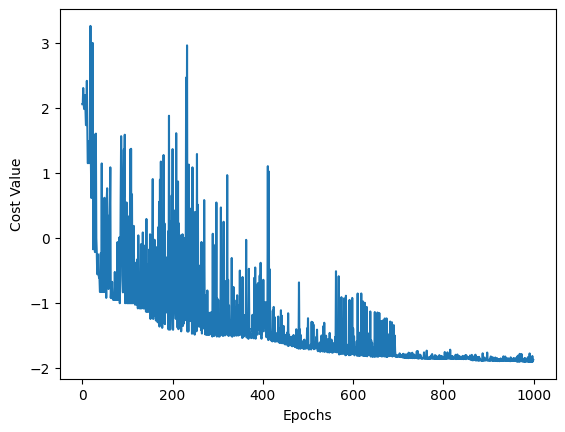

In [9]:
import matplotlib.pyplot as plt

x_values = list(range(len(cost_values)))
y_values = cost_values

plt.plot(x_values, y_values)

plt.xlabel("Epochs")
plt.ylabel("Cost Value")
plt.show()